In [33]:
import re
import os
import pathlib
import json
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "01_http_max_throughput"
file_prefix = "exp-01"

In [3]:
"""Load cleaned/aggregated data sets

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

resource_df = pd.read_feather(data_dir / "resource_results.feather")
# fortio_df = pd.read_feather(data_dir / "fortio_results.feather")

In [4]:
"""
Prepares the experiment data

"""

exp = resource_df[resource_df["experiment"] == exp_name]
exp.head()

,experiment,mesh,requested_qps,pod,container,cpu,mem,date,delta
0,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.000719,1072.776342,2022-06-26 14:31:58,0 days 00:00:00
1,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.000719,1072.776342,2022-06-26 14:32:01,0 days 00:00:03
2,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.049509,18820.872955,2022-06-26 14:32:04,0 days 00:00:06
3,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.063200,24103.189715,2022-06-26 14:32:07,0 days 00:00:09
4,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.063200,24103.189715,2022-06-26 14:32:10,0 days 00:00:12


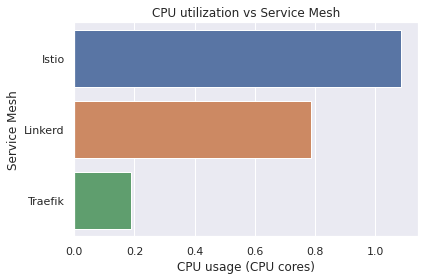

In [5]:
"""
PLOT: Boxplot CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-box_cpu.pdf"
plot_title = "CPU utilization vs Service Mesh"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]
data = data.groupby(["mesh"]).mean().reset_index().sort_values(by="cpu", ascending=False)

ax = sns.barplot(data=data, x="cpu", y="mesh")

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("CPU usage (CPU cores)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
# fig.savefig(plot_dir / file_name)

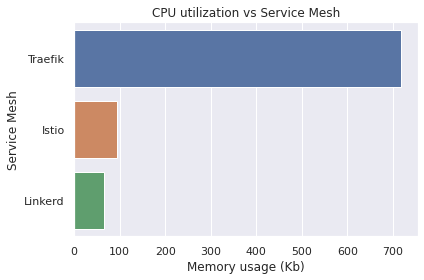

In [6]:
"""
PLOT: Boxplot CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-box_mem.pdf"
plot_title = "CPU utilization vs Service Mesh"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]
data["mem"] /= 1000
data = data.groupby(["mesh"]).mean().reset_index().sort_values(by="mem", ascending=False)

ax = sns.barplot(data=data, x="mem", y="mesh")

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Memory usage (Kb)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
# fig.savefig(plot_dir / file_name)


Text(0.5, 0.98, 'CPU utilization vs Service Mesh')

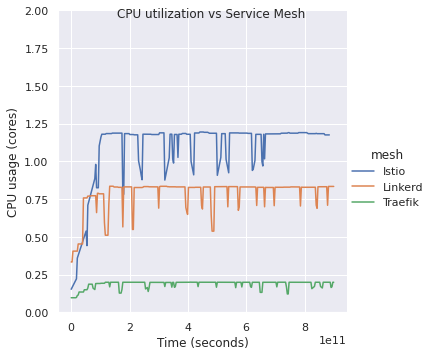

In [11]:
# file_name = f"{file_prefix}-line_cpu.pdf"
# plot_title = "CPU utilization vs Service Mesh"

data = exp[(exp["container"] != "fortio") & (exp["mesh"] != "Cilium")]
g = sns.relplot(data=data, x="delta", y="cpu", hue="mesh", kind="line")
g.set(ylim=(0, 2))
g.set_ylabels("CPU usage (cores)")
g.set_xlabels("Time (seconds)")

g.fig.suptitle(plot_title)

# g.savefig(plot_dir / file_name)

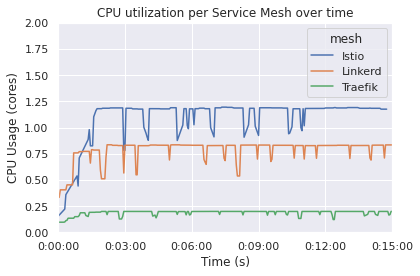

In [53]:
"""
PLOT:Line CPU usage by mesh
Desc: 
"""



file_name = f"{file_prefix}-line-cpu.pdf"
plot_title = "CPU utilization per Service Mesh over time"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]

# Adds time delta per experiment
# data["delta"] = data.sort_values(["mesh", "date"]).groupby("mesh")["date"].transform(lambda x: x - x.min())
data["mem"] /= 1000

sns.lineplot(data=data, x="delta", y="cpu", hue="mesh", ax=ax)

# Labels
ax.set_ylabel("CPU Usage (cores)")
ax.set_xlabel("Time (s)")
ax.set_title(plot_title)

ax.set_xlim(0, 15 * 60 * 10e8)
ax.set_ylim(0, 2)

def timeTicks(x, pos):
    seconds = x / 10**9 # convert nanoseconds to seconds
    # create datetime object because its string representation is alright
    d = datetime.timedelta(seconds=seconds)
    return str(d)

formatter = ticker.FuncFormatter(timeTicks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=6))

# ax.set_xscale("log")

# Second plot with cumulative density
# ax2 = ax.twinx()
# ax2.set_alpha(0.5)
# ax2.grid(False)
# sns.lineplot(data=data, x="delta", y="mem", hue="mesh", ax=ax)
# # ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)


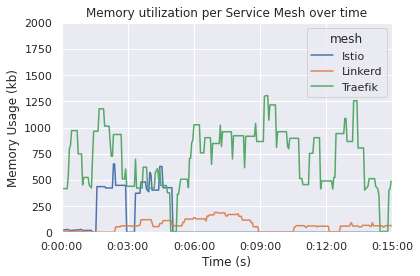

In [55]:

"""
PLOT:Line CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-line-mem.pdf"
plot_title = "Memory utilization per Service Mesh over time"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]

# Adds time delta per experiment
# data["delta"] = data.sort_values(["mesh", "date"]).groupby("mesh")["date"].transform(lambda x: x - x.min())
data["mem"] /= 1000

sns.lineplot(data=data, x="delta", y="mem", hue="mesh", ax=ax)

# Labels
ax.set_ylabel("Memory Usage (kb)")
ax.set_xlabel("Time (s)")
ax.set_title(plot_title)

ax.set_xlim(0, 15 * 60 * 10e8)
ax.set_ylim(0, 2000)

def timeTicks(x, pos):
    seconds = x / 10**9 # convert nanoseconds to seconds
    # create datetime object because its string representation is alright
    d = datetime.timedelta(seconds=seconds)
    return str(d)

formatter = ticker.FuncFormatter(timeTicks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=6))


# ax.set_xscale("log")

# Second plot with cumulative density
# ax2 = ax.twinx()
# ax2.set_alpha(0.5)
# ax2.grid(False)
# sns.lineplot(data=data, x="delta", y="mem", hue="mesh", ax=ax)
# # ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)
